# Finance Analyzer — Analysis & Chart Exploration Notebook

⚠️ **Purpose of this notebook**

This notebook is intentionally **exploratory and exhaustive**.

- It tries *all reasonable charting and aggregation ideas* on the enriched PhonePe dataset.
- Some charts will feel redundant or noisy — **that is expected**.
- The goal is to decide:
  - Which charts are **important enough** for the default app dashboard
  - Which charts should remain **optional / user-driven**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

ENRICHED_CSV_PATH = Path('../data/phonepe_spendings_enriched.csv')


In [2]:
import sys
from pathlib import Path

# Add project root to Python path
project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [3]:
if not ENRICHED_CSV_PATH.exists():
    raise FileNotFoundError(f'Enriched CSV not found: {ENRICHED_CSV_PATH}')

df = pd.read_csv(ENRICHED_CSV_PATH, parse_dates=['Date'])
df.head()

,Date,Merchant,Type,Amount,Month,Day,Day_Of_Week,Week_Number,SpendBucket,Category,Is_Weekend,Day_Type
0,2025-09-02,ASMITA MEDICAL,DEBIT,90.0,Sep-2025,2,Tuesday,36,Small,Other,False,Weekday
1,2025-09-02,More sweet and snacks,DEBIT,25.0,Sep-2025,2,Tuesday,36,Small,Food,False,Weekday
2,2025-09-02,Nagori Tea,DEBIT,20.0,Sep-2025,2,Tuesday,36,Small,Food,False,Weekday
3,2025-09-01,Nagori Tea,DEBIT,200.0,Sep-2025,1,Monday,36,Small,Food,False,Weekday
4,2025-09-01,Hotel Aswad,DEBIT,160.0,Sep-2025,1,Monday,36,Small,Food,False,Weekday


## 1️⃣ Dataset Overview


In [4]:
print('Total transactions:', len(df))
print('Date range:', df['Date'].min(), '→', df['Date'].max())

df.info()

Total transactions: 411
Date range: 2025-06-04 00:00:00 → 2025-09-02 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 411 entries, 0 to 410
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         411 non-null    datetime64[ns]
 1   Merchant     411 non-null    object        
 2   Type         411 non-null    object        
 3   Amount       411 non-null    float64       
 4   Month        411 non-null    object        
 5   Day          411 non-null    int64         
 6   Day_Of_Week  411 non-null    object        
 7   Week_Number  411 non-null    int64         
 8   SpendBucket  411 non-null    object        
 9   Category     411 non-null    object        
 10  Is_Weekend   411 non-null    bool          
 11  Day_Type     411 non-null    object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2), object(7)
memory usage: 35.8+ KB


## 2️⃣ Core Summary Metrics


In [5]:
summary = {}
summary['Total Debit'] = df[df['Type'].str.upper() == 'DEBIT']['Amount'].sum()
summary['Total Credit'] = df[df['Type'].str.upper() == 'CREDIT']['Amount'].sum()
summary['Net'] = summary['Total Credit'] - summary['Total Debit']
summary['Transactions'] = len(df)
summary['Average Transaction'] = df['Amount'].mean()

pd.Series(summary)

Total Debit            100791.000000
Total Credit                0.000000
Net                   -100791.000000
Transactions              411.000000
Average Transaction       245.233577
dtype: float64

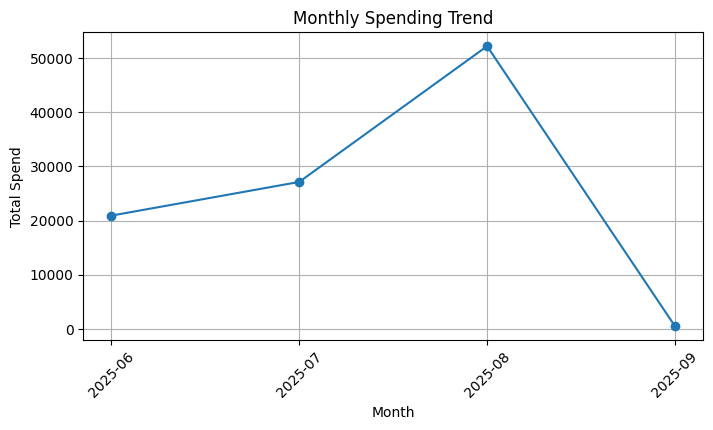

In [6]:
# Monthly Spending Trend

monthly = df.groupby(df["Date"].dt.to_period("M"))["Amount"].sum()
monthly.index = monthly.index.astype(str)

plt.figure(figsize=(8,4))
plt.plot(monthly.index, monthly.values, marker="o")
plt.title("Monthly Spending Trend")
plt.xlabel("Month")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

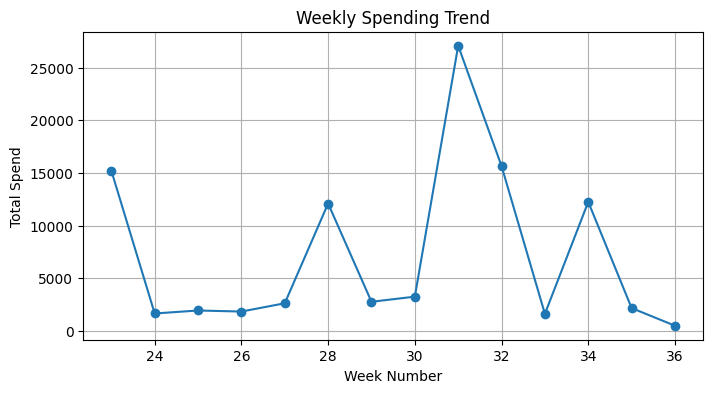

In [7]:
# Weekly Spending Trend
weekly = df.groupby("Week_Number")["Amount"].sum().sort_index()

plt.figure(figsize=(8,4))
plt.plot(weekly.index, weekly.values, marker="o")
plt.title("Weekly Spending Trend")
plt.xlabel("Week Number")
plt.ylabel("Total Spend")
plt.grid(True)
plt.show()

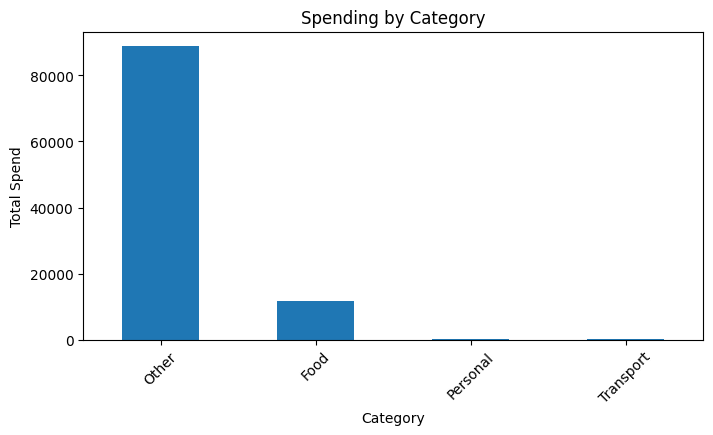

In [8]:
# Category-wise Spending
cat = df.groupby("Category")["Amount"].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
cat.plot(kind="bar")
plt.title("Spending by Category")
plt.ylabel("Total Spend")
plt.xticks(rotation=45)
plt.show()

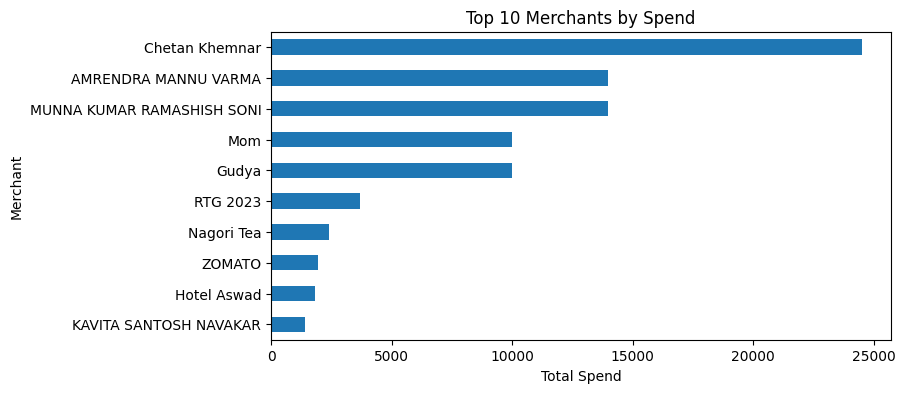

In [9]:
# Top Merchants by Spend
top_merchants = (
    df.groupby("Merchant")["Amount"]
      .sum()
      .sort_values(ascending=False)
      .head(10)
)

plt.figure(figsize=(8,4))
top_merchants.plot(kind="barh")
plt.title("Top 10 Merchants by Spend")
plt.xlabel("Total Spend")
plt.gca().invert_yaxis()
plt.show()

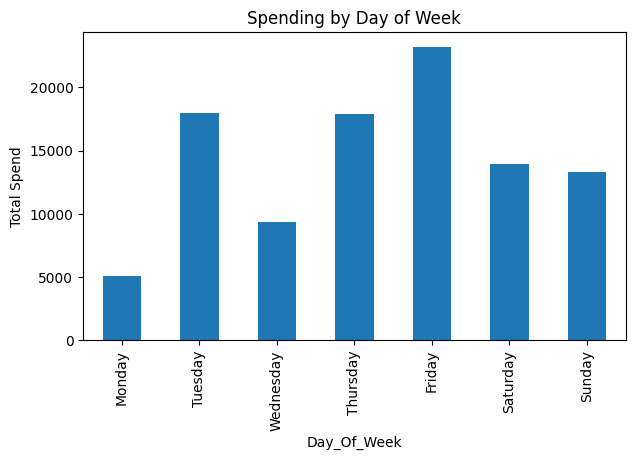

In [10]:
#Spending by Day of Week
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow = df.groupby("Day_Of_Week")["Amount"].sum().reindex(dow_order)

plt.figure(figsize=(7,4))
dow.plot(kind="bar")
plt.title("Spending by Day of Week")
plt.ylabel("Total Spend")
plt.show()

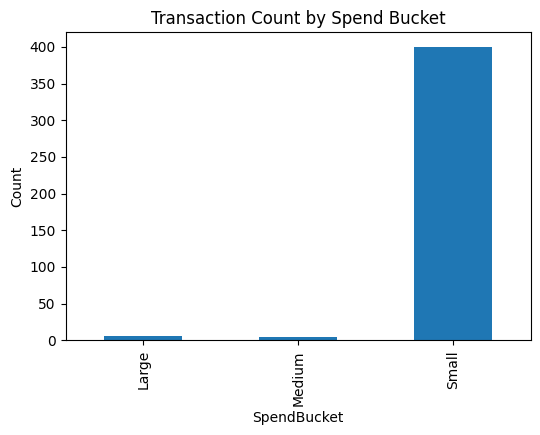

In [11]:
# Spend Bucket Distribution
bucket = df.groupby("SpendBucket")["Amount"].count()

plt.figure(figsize=(6,4))
bucket.plot(kind="bar")
plt.title("Transaction Count by Spend Bucket")
plt.ylabel("Count")
plt.show()

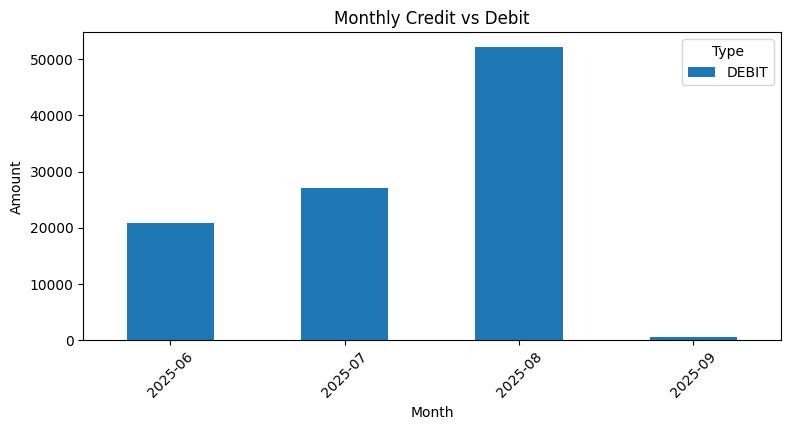

In [12]:
# Monthly Credit vs Debit
monthly_cd = (
    df.groupby([df["Date"].dt.to_period("M"), "Type"])["Amount"]
      .sum()
      .unstack(fill_value=0)
)
monthly_cd.index = monthly_cd.index.astype(str)

monthly_cd.plot(kind="bar", figsize=(9,4))
plt.title("Monthly Credit vs Debit")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.show()

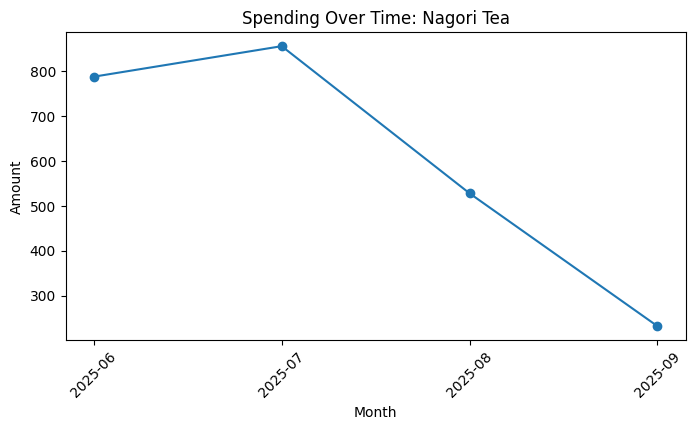

In [13]:
# Single Merchant Over Time
merchant_name = "Nagori Tea"  # change dynamically later
m_df = df[df["Merchant"] == merchant_name]

m_monthly = m_df.groupby(m_df["Date"].dt.to_period("M"))["Amount"].sum()
m_monthly.index = m_monthly.index.astype(str)

plt.figure(figsize=(8,4))
plt.plot(m_monthly.index, m_monthly.values, marker="o")
plt.title(f"Spending Over Time: {merchant_name}")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.show()

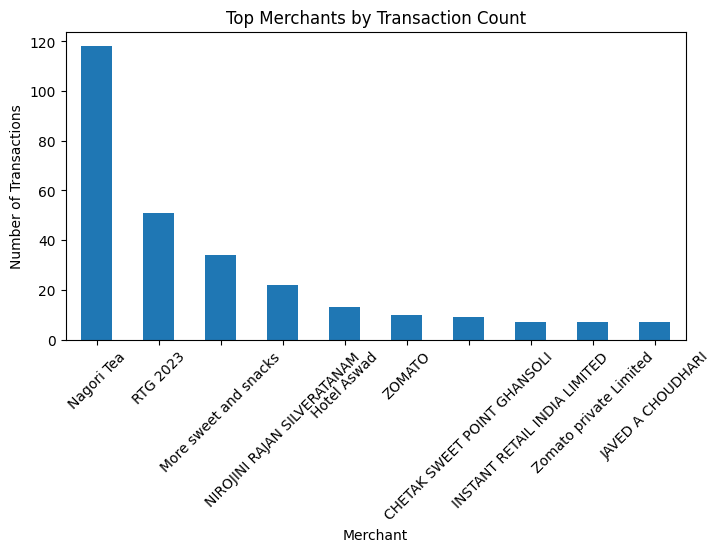

In [14]:
# Top Merchants by Transaction Count
merchant_count = df["Merchant"].value_counts().head(10)

plt.figure(figsize=(8,4))
merchant_count.plot(kind="bar")
plt.title("Top Merchants by Transaction Count")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

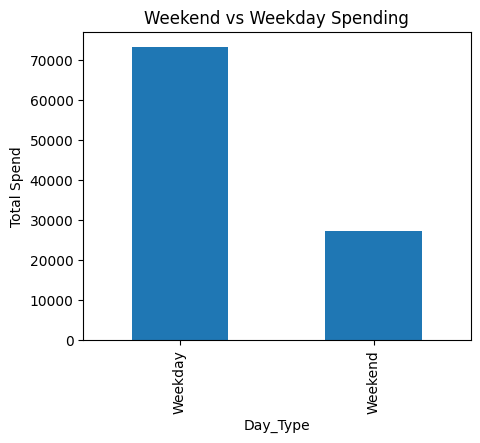

In [15]:
# Weekend vs Weekday Spend
day_type = df.groupby("Day_Type")["Amount"].sum()

plt.figure(figsize=(5,4))
day_type.plot(kind="bar")
plt.title("Weekend vs Weekday Spending")
plt.ylabel("Total Spend")
plt.show()

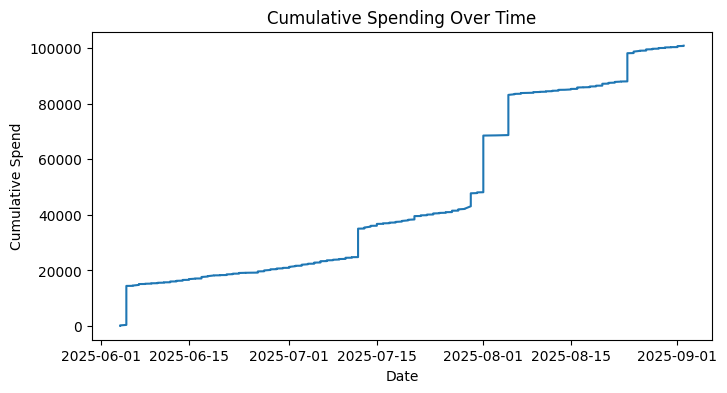

In [16]:
# Cumulative Spending Over Time
df_sorted = df.sort_values("Date")
df_sorted["Cumulative_Spend"] = df_sorted["Amount"].cumsum()

plt.figure(figsize=(8,4))
plt.plot(df_sorted["Date"], df_sorted["Cumulative_Spend"])
plt.title("Cumulative Spending Over Time")
plt.xlabel("Date")
plt.ylabel("Cumulative Spend")
plt.show()

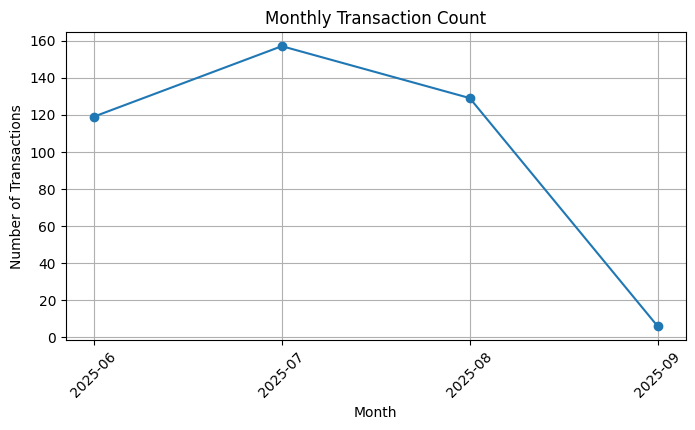

In [17]:
# Monthly Transaction Count
monthly_tx = df.groupby(df["Date"].dt.to_period("M")).size()
monthly_tx.index = monthly_tx.index.astype(str)

plt.figure(figsize=(8,4))
plt.plot(monthly_tx.index, monthly_tx.values, marker="o")
plt.title("Monthly Transaction Count")
plt.xlabel("Month")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

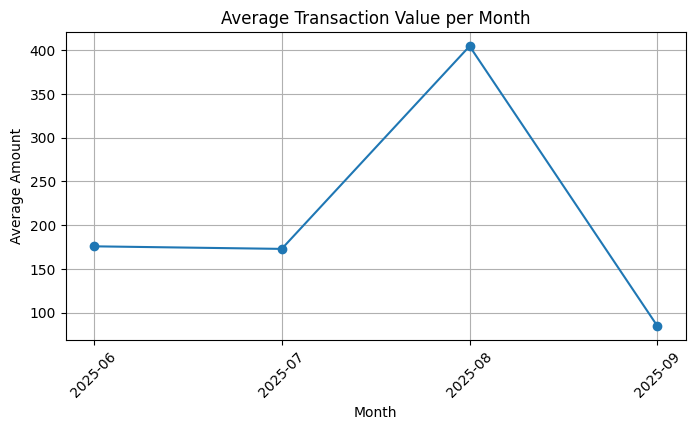

In [18]:
# Average Transaction Value per Month
monthly_avg = df.groupby(df["Date"].dt.to_period("M"))["Amount"].mean()
monthly_avg.index = monthly_avg.index.astype(str)

plt.figure(figsize=(8,4))
plt.plot(monthly_avg.index, monthly_avg.values, marker="o")
plt.title("Average Transaction Value per Month")
plt.xlabel("Month")
plt.ylabel("Average Amount")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

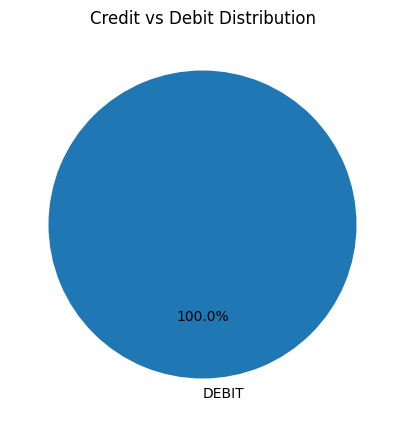

In [19]:
# Credit vs Debit Distribution
type_dist = df["Type"].value_counts()

plt.figure(figsize=(5,5))
plt.pie(type_dist.values, labels=type_dist.index, autopct="%1.1f%%", startangle=90)
plt.title("Credit vs Debit Distribution")
plt.show()

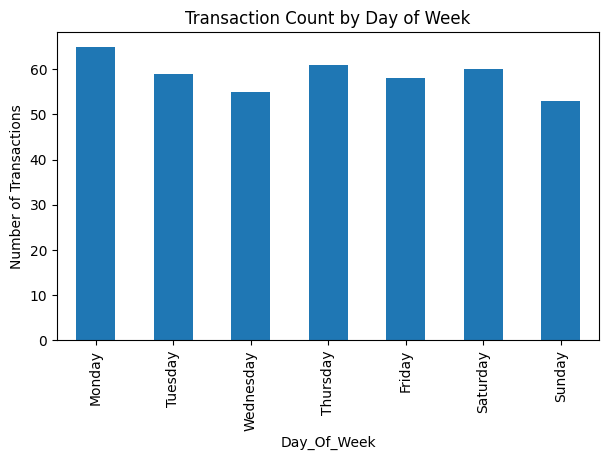

In [20]:
# Transaction Count by Day of Week
dow_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
dow_count = df.groupby("Day_Of_Week").size().reindex(dow_order)

plt.figure(figsize=(7,4))
dow_count.plot(kind="bar")
plt.title("Transaction Count by Day of Week")
plt.ylabel("Number of Transactions")
plt.show()

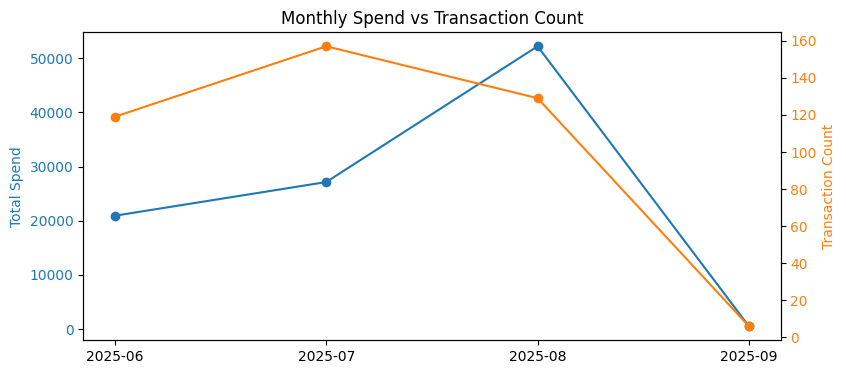

In [21]:
# Spend vs Transaction Count by Month
monthly_sum = df.groupby(df["Date"].dt.to_period("M"))["Amount"].sum()
monthly_count = df.groupby(df["Date"].dt.to_period("M")).size()

monthly_sum.index = monthly_sum.index.astype(str)
monthly_count.index = monthly_count.index.astype(str)

fig, ax1 = plt.subplots(figsize=(9,4))

ax1.plot(monthly_sum.index, monthly_sum.values, marker="o", color="tab:blue")
ax1.set_ylabel("Total Spend", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.plot(monthly_count.index, monthly_count.values, marker="o", color="tab:orange")
ax2.set_ylabel("Transaction Count", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

plt.title("Monthly Spend vs Transaction Count")
plt.xticks(rotation=45)
plt.show()

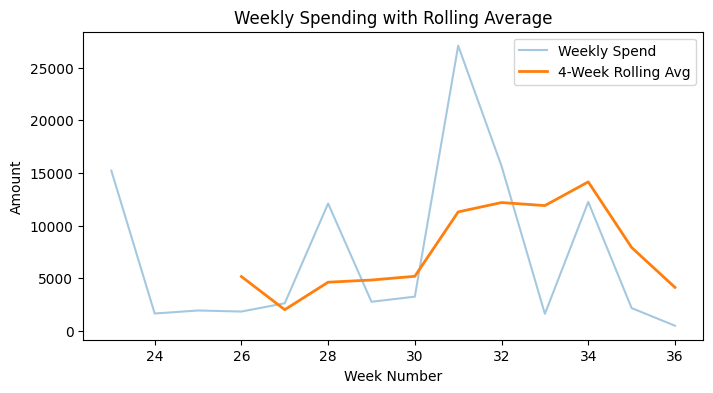

In [22]:
# Rolling 4-Week Spending Average
weekly = df.groupby("Week_Number")["Amount"].sum().sort_index()
rolling = weekly.rolling(window=4).mean()

plt.figure(figsize=(8,4))
plt.plot(weekly.index, weekly.values, alpha=0.4, label="Weekly Spend")
plt.plot(rolling.index, rolling.values, linewidth=2, label="4-Week Rolling Avg")
plt.title("Weekly Spending with Rolling Average")
plt.xlabel("Week Number")
plt.ylabel("Amount")
plt.legend()
plt.show()

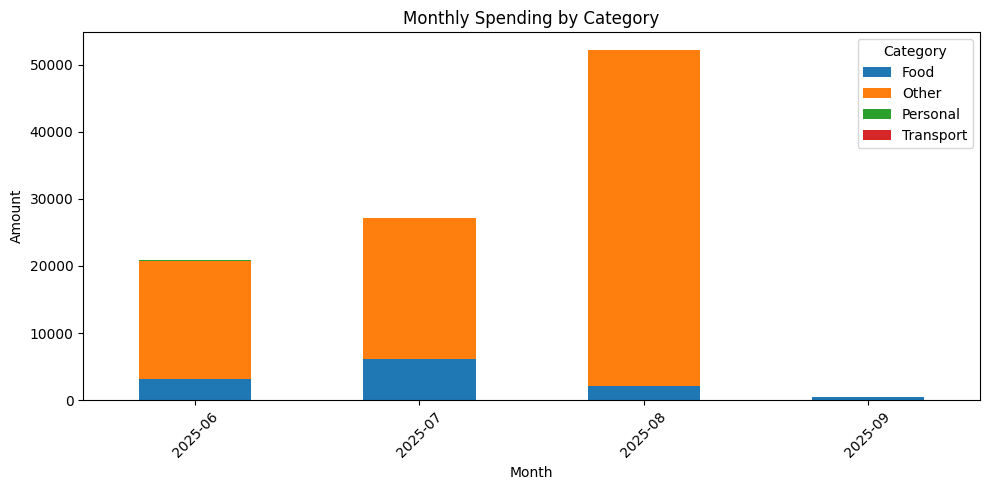

In [23]:
# Monthly Category Mix
monthly_cat = (
    df.groupby([df["Date"].dt.to_period("M"), "Category"])["Amount"]
      .sum()
      .unstack(fill_value=0)
)

monthly_cat.index = monthly_cat.index.astype(str)

monthly_cat.plot(kind="bar", stacked=True, figsize=(10,5))
plt.title("Monthly Spending by Category")
plt.xlabel("Month")
plt.ylabel("Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

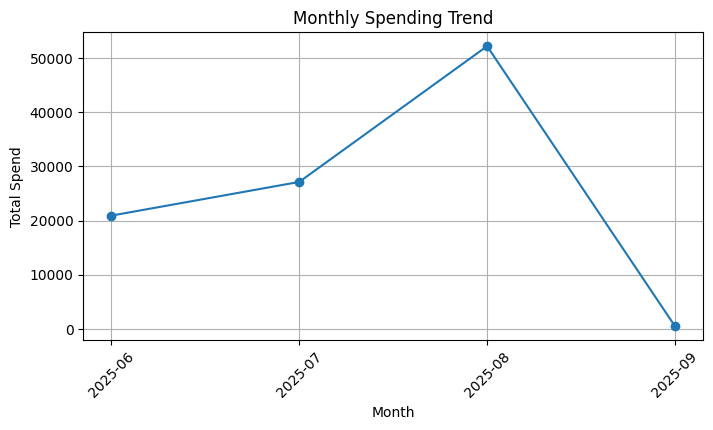

In [24]:
from src.charts import plot_monthly_spending

fig = plot_monthly_spending(df)

In [25]:
from src.charts import (
    plot_monthly_top_entities,
    plot_date_range_trend,
    plot_week_comparison,
    _validate_df
)

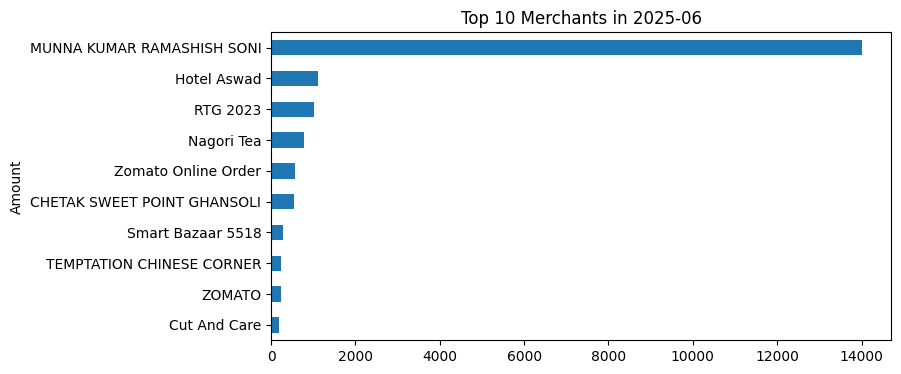

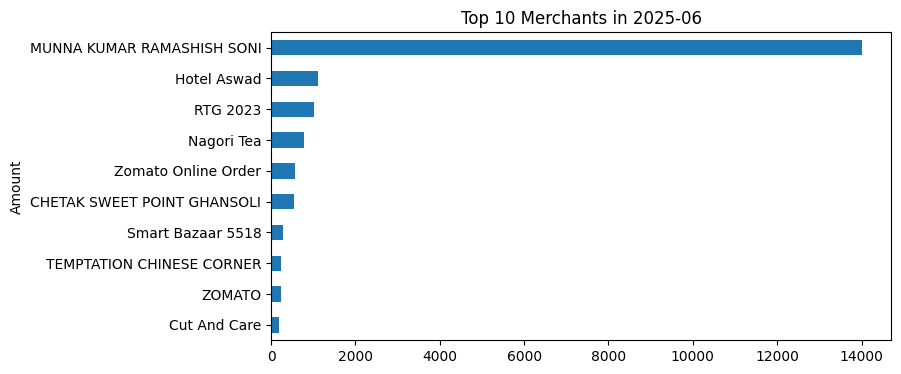

In [26]:
plot_monthly_top_entities(df, month="2025-06")

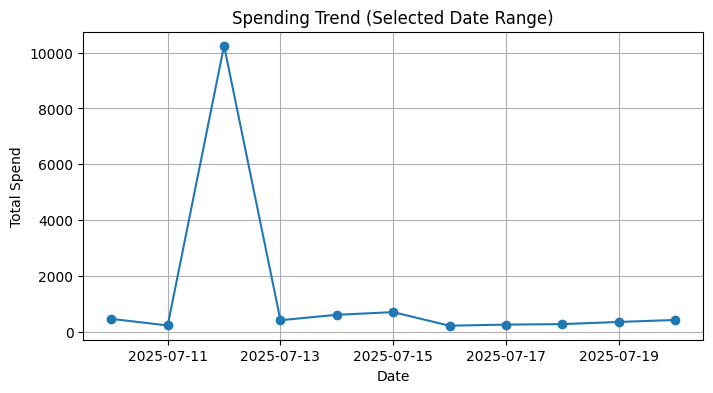

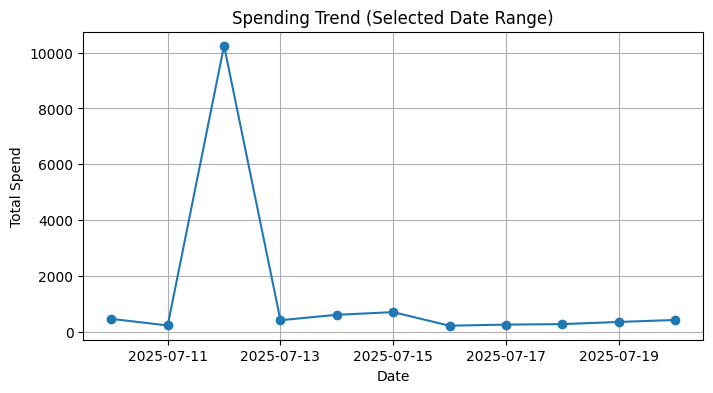

In [27]:
plot_date_range_trend(df, "2025-07-10", "2025-07-20")

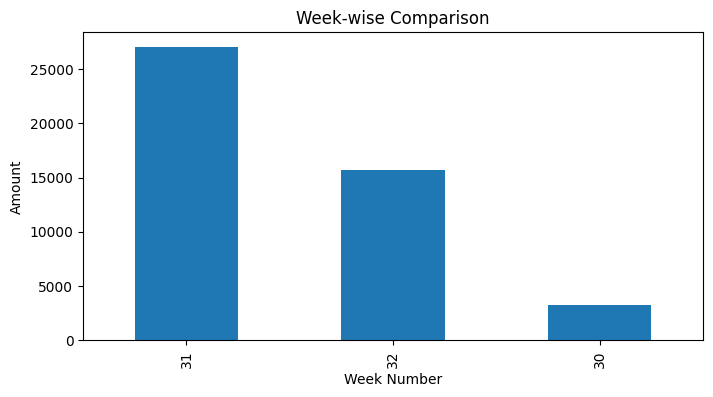

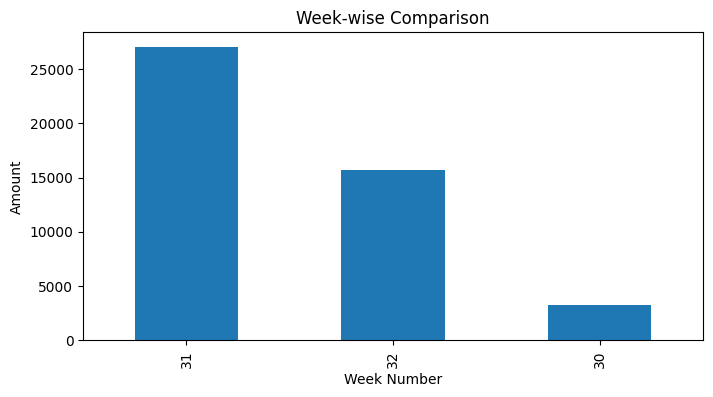

In [28]:
plot_week_comparison(df, weeks=[30, 31, 32])

In [29]:
from src.charts import (
    plot_monthly_spending,
    plot_weekly_spending,
    plot_category_spending,
    plot_top_merchants,
    plot_monthly_top_entities,
    plot_date_range_trend,
    plot_week_comparison
)

In [30]:
empty_df = pd.DataFrame()

plot_monthly_spending(empty_df)

ValueError: Input DataFrame is empty or None.

In [32]:
plot_date_range_trend(df, "2025-03-10", "2025-02-01")

ValueError: start_date must be before end_date.

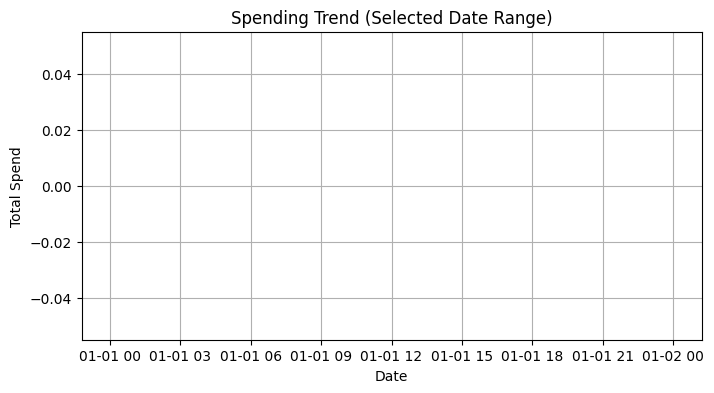

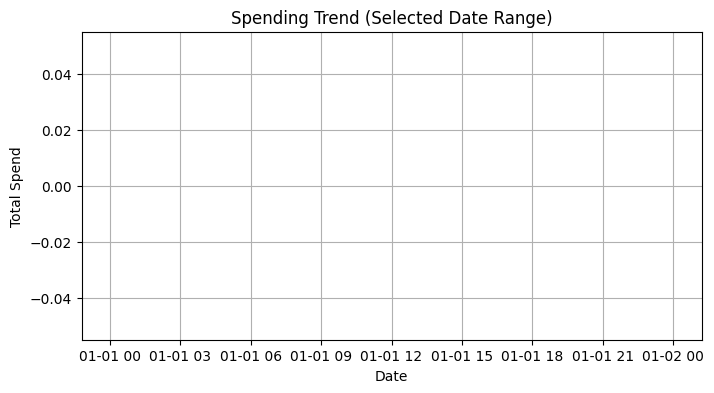

In [33]:
plot_date_range_trend(df, "2010-01-01", "2010-02-01")

In [34]:
plot_monthly_top_entities(
    df,
    month="2025-03",
    group_by="Merchant",
    metric="total"  # invalid
)


ValueError: Input DataFrame is empty or None.

In [41]:
from src.insights import *


#total_spend_in_month(df, "2025-07")
#transaction_count_in_month(df, "2025-08")
#top_merchant_in_month(df, "2025-07")
#weekend_vs_weekday_spend(df, "2025-07")
highest_spending_week_in_month(df, "2025-07")

{'week': 28, 'amount': 12104.0}